# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import os
import logging

# Disable TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.WARNING)

import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D , Flatten
from keras.optimizers import Adam

E0000 00:00:1732073422.891089   36134 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732073422.895440   36134 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Get a list of training dog and cat images
training_dogs=glob.glob('../data/raw/train/dog/dog.*')
training_cats=glob.glob('../data/raw/train/cat/cat.*')

### 1.2. Inspect

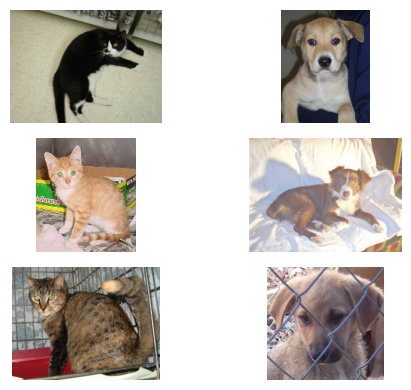

In [3]:
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

### 1.3. Prepare images for streaming

In [4]:
# Define a few rules for DataGen
training_data_path='../data/raw/train/'
image_size=(200, 200)

data_generator=ImageDataGenerator()

# Train Data Generation
train_data=data_generator.flow_from_directory(
    training_data_path,
    target_size=image_size,
    classes=['dog', 'cat'] 
)

Found 25000 images belonging to 2 classes.


## 2. Model

### 2.1. Model definition

In [ ]:
# Instantiate an empty sequential model
model = Sequential()

# Add the VGG16 convolutional stack
model.add(Input((220,220,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
#model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Flattent the output from the covolutions
model.add(Flatten())

# Add dense layers
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

# Compile the Model before Training
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,520,834 (211.80 MB)

 Trainable params: 55,520,834 (211.80 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2. Model training

In [ ]:
training_results=model.fit(train_data, steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5226 - loss: 0.6929
Epoch 2/5
 6/50 ━━━━━━━━━━━━━━━━━━━━ 2:21 3s/step - accuracy: 0.6415 - loss: 0.6825

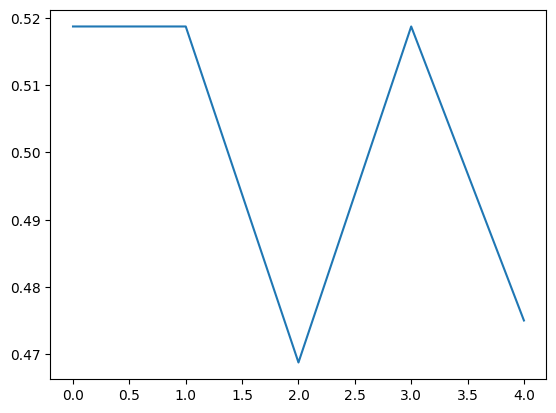

In [ ]:
plt.plot(training_results.history["accuracy"])
plt.show()